# (1) Assimilate the business scenario and articulate testable hypotheses.
	About AAVAIL Company:
		AAVAIL provides a streaming service similar to Netflix, Amazon Prime, they offer local, national and international news to its subscriber in 12 language. he news feed is piped through the service and both the speaker's voice and the movement of their lips are modified to match the language the subscriber has selected. There are separate deep-learning models for the image and audio portions of the service, but the experience is seamless from the standpoint of the user
		
		Company engaged their sales and marketing team to increase campaign, modifying the pricing model, refining the product and more, with the goal of driving the product’s growth in the new markets
		
	Business scenario and testable hypotheses:
		As a data scientist, business scenario is to project a particular country's revenue for the following month using a machine learning model that will provide revenue estimates and confidence measures for those estimates.

		Company have sufficient customer invoice related data in well-structured format, which would need to analysis and process to build the forecasting model to achieve the required goal.


# (2) State the ideal data to address the business opportunity and clarify the rationale for needing specific data.
			As per the business scenario, we need to project the monthly forecasting, and the forecasting is only possible, if we would have the historical data. So We need customer invoice related historical data from across all geography location, where company provide the services. 

In [1]:
import os, json, sys,re,io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import fbprophet


In [2]:
#sys.path.append('C:\\Users\\DineshNaik\\IBM-AI-Learning\\Aavail-Capstone-Proj\\Notebook\\')
from data_ingestor import *
from time_series import *

# (3) Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.
			Relevant data is available in multiple data format, where different file has different column label and non-numeric invoice number. We have built process to clean the data to achieve the goal accurately.
            During the data ingestion process, rename duplicate header label and remove the alpha numeric char from the invoice no.


In [3]:
FILE_PATH = "C:\Dinesh\Personal\Learning\IBM-AI-Data-Scientist\Capstone-Part-1\Data\cs-train"
df = read_json_files(FILE_PATH)
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [4]:
df_clean = df.copy()
df_clean.drop(['customer_id'],axis=1,inplace=True)
df_clean = datatype_map(df_clean)
df_clean.head()

,country,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,28,489434,11,1.65,22064,17,2017,2017-11-28


Gathering top 10 country based on the high price

In [5]:
df_country_inv_amt = df_clean.groupby(['country']).agg({'times_viewed':'sum','price':'sum'}).reset_index()
df_country_inv_amt = df_country_inv_amt.sort_values('price',ascending=False).head(10).set_index('country')
top_ten_countries =  np.array(list(df_country_inv_amt.index))[:10]
df_country_inv_amt.head(10)

,times_viewed,price
country,,
United Kingdom,3725703,3.521514e+06
EIRE,111636,1.070692e+05
Germany,112618,4.927182e+04
France,83124,4.056514e+04
Norway,7881,3.849475e+04
Spain,19573,1.604099e+04
Hong Kong,2635,1.445257e+04
Portugal,14195,1.352867e+04
Singapore,3042,1.317592e+04


(0.0, 100000.0)

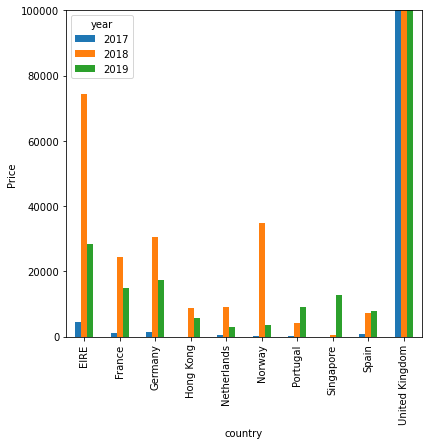

In [6]:
df_country_inv_amt = df_clean.groupby(['country','year']).agg({'times_viewed':'sum','price':'sum'}).reset_index()
df_country_inv_amt = df_country_inv_amt[df_country_inv_amt['country'].isin(top_ten_countries)]

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

price_table = pd.pivot_table(df_country_inv_amt,index='country',columns='year',values="price")
price_table.plot(kind='bar',ax=ax1)
ax1.set_ylabel("Price");

## adjust the axis to accomadate the legend
ax1.set_ylim((0,100000))

(0.0, 150000.0)

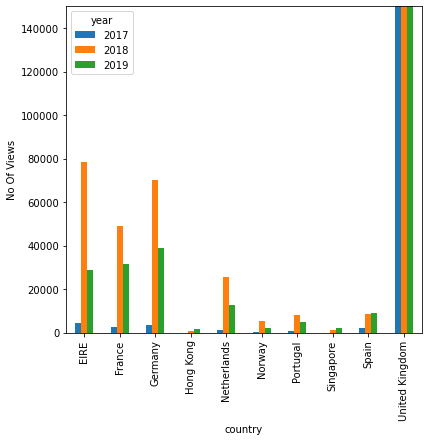

In [7]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

price_table = pd.pivot_table(df_country_inv_amt,index='country',columns='year',values="times_viewed")
price_table.plot(kind='bar',ax=ax1)
ax1.set_ylabel("No Of Views");

## adjust the axis to accomadate the legend
ax1.set_ylim((0,150000))

In [8]:
df_desc = df_clean.groupby(['country','year','month']).agg({'times_viewed':'sum', 'price':'sum',}).reset_index()
df_desc['year_month'] = df_desc['year'].astype(str)+'-'+df_desc['month'].apply(lambda x: str(x).zfill(2))
df_desc.drop(['year','month','times_viewed'],axis=1,inplace=True)
df_desc.groupby(['year_month']).describe()

price                                                        \
           count          mean           std    min       25%      50%   
year_month                                                               
2017-11     14.0   2939.482143  10508.409669   2.10   15.1450   89.665   
2017-12     20.0   7857.750500  32949.643586   4.85   78.8050  127.995   
2018-01     22.0   8349.108818  33293.690189   9.24  118.3625  309.450   
2018-02     18.0   6463.631889  24208.928621   9.70   71.6500  243.830   
2018-03     22.0  11701.292773  45186.397422  18.40   94.8475  257.100   
2018-04     23.0   5071.406174  21416.658119   1.65   62.3700  199.940   
2018-05     20.0   7787.439500  30308.021273  20.72  115.4450  677.810   
2018-06     25.0   9163.977600  43483.640810  10.30   76.8500  135.360   
2018-07     20.0   5418.936500  20309.757575  18.65  100.1125  202.210   
2018-08     24.0   6525.208333  27584.140734  25.20  150.3675  223.510   
2018-09     27.0   8240.777074  39281.636274  30.08   76.4700  230.890   
2018-10     28.0   9977.170714  45825.656692  14.56   71.4600  407.525   
2018-11     28.0  11970.389714  59057.627811  23.30  128.7375  421.300   
2018-12     23.0  15871.806957  73884.381658   3.81   91.0700  185.940   
2019-01     26.0   7235.025385  33696.056864   3.81  100.1400  252.890   
2019-02     23.0   5585.953913  24252.611663  24.11   66.2150  257.200   
2019-03     25.0   6462.919600  27657.735928   2.94   92.0600  282.020   
2019-04     26.0   5867.940423  25511.866724  17.90   75.0475  152.210   
2019-05     22.0   8043.915000  33153.494187   1.06  131.6200  363.430   
2019-06     25.0   7597.090000  33789.682096   4.80  113.2000  175.760   
2019-07     26.0   7394.478500  34799.202829  26.02   78.4675  215.900   

                                   
                  75%         max  
year_month                         
2017-11      195.6825   39445.590  
2017-12      843.3825  147795.480  
2018-01     1270.2500  156741.514  
2018-02     1488.6975  103386.264  
2018-03      903.1575  211490.981  
2018-04      719.8800  103206.131  
2018-05     1470.6575  136435.360  
2018-06      406.9600  217849.500  
2018-07      711.7000   91460.410  
2018-08     1234.7475  135892.280  
2018-09      559.2400  204623.941  
2018-10      847.9700  243017.000  
2018-11      789.0350  313246.222  
2018-12      346.5800  354786.040  
2019-01      433.9400  172359.770  
2019-02     1086.5600  116808.970  
2019-03      549.4700  138856.410  
2019-04      394.6900  130373.041  
2019-05      805.4200  156283.740  
2019-06      738.5700  169493.000  
2019-07      647.5225  177961.861

2) Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.

Plotting time-series

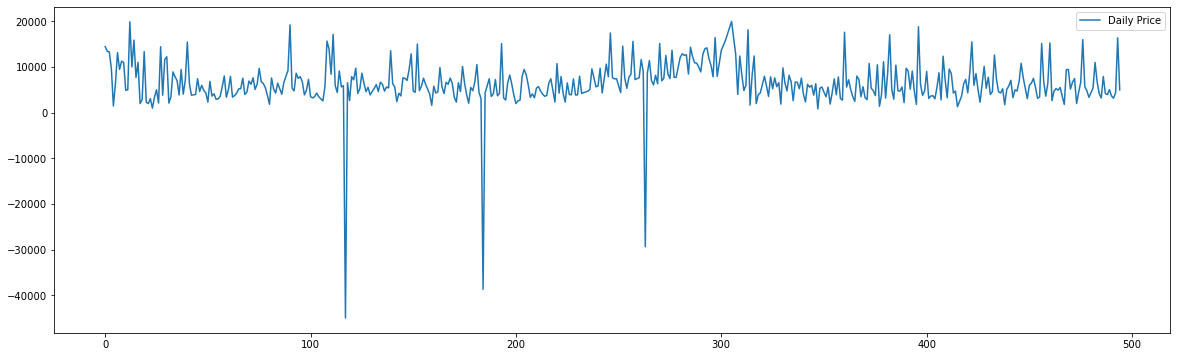

In [9]:
# checking stationarity of a time-series on a daily basis
df_day = df_clean.groupby(['invoice_date']).agg({'times_viewed':'sum', 'price':'sum', 'country':'first',}).reset_index()
df_day = df_day[df_day['price']<=20000]

df_day['price'].plot(figsize=(20,6),label='Daily Price') #Eliminate price outliner for > 20000
plt.legend(loc='best')

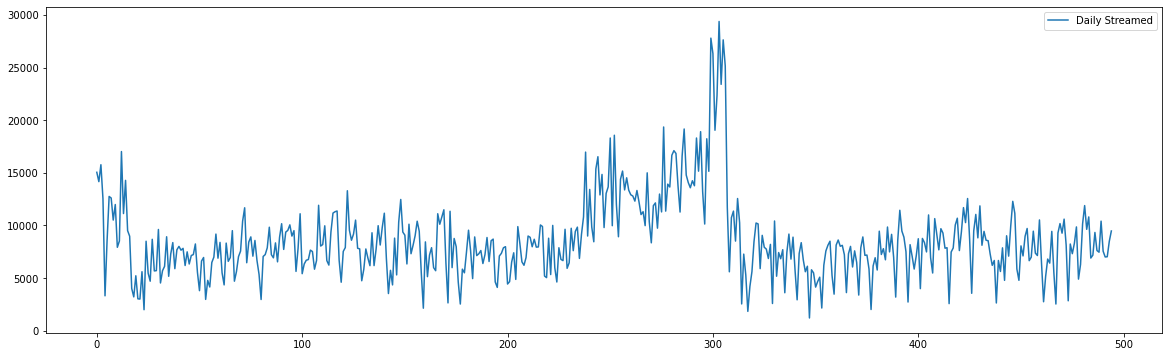

In [10]:
df_day = df_clean.groupby(['invoice_date']).agg({'times_viewed':'sum', 'price':'sum', 'country':'first',}).reset_index()
df_day['times_viewed'].plot(figsize=(20,6), label='Daily Streamed')
plt.legend(loc='best')

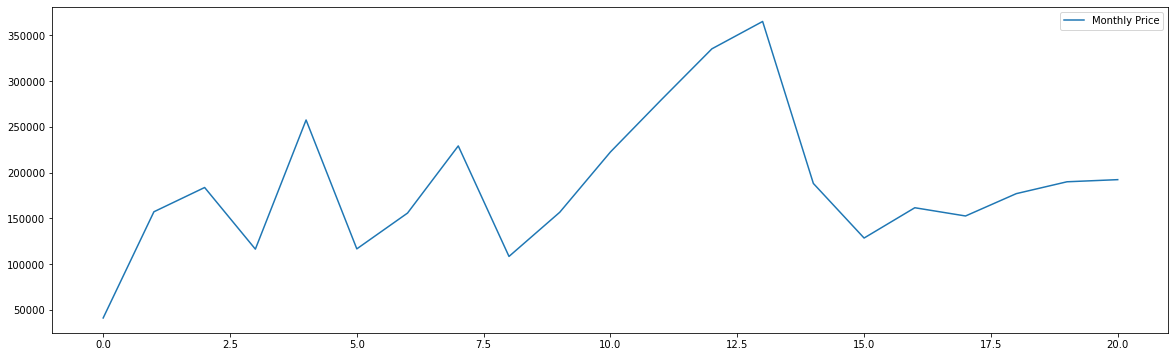

In [11]:
# checking stationarity of a time-series on a monthly basis
df_month = df_clean.groupby(['year','month']).agg({'times_viewed':'sum', 'price':'sum', 'country':'first',}).reset_index()
df_month['price'].plot(figsize=(20,6),label='Monthly Price')
plt.legend(loc='best')

Stationarity check of time series

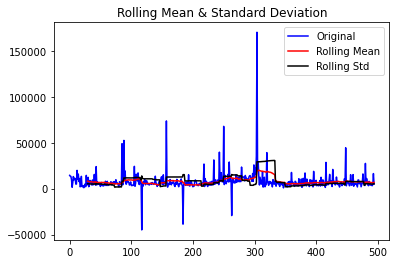

Result for Dickey-Fuller Test:
Test Statistic                 -19.628804
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    494.000000
Critical value(1%)              -3.443657
Critical value(5%)              -2.867408
Critical value(10%)             -2.569896
dtype: float64


C:\Users\DineshNaik\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


In [12]:
rol_day=30
get_stationarity(df_day['price'],rol_day)

For carrying out time-series forecasting, the Test statistic value is even smaller than 1% of the critical value. Therefore, it can be concluded that the time-series is stationary.

Fitting ARIMA time series model to untransformed data

C:\Users\DineshNaik\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\DineshNaik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\DineshNaik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


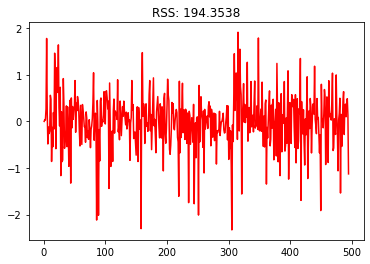

In [13]:
fit_ARIMA(df_day['price'],1)

Decomposing the time series into trend, seasonality and residuals

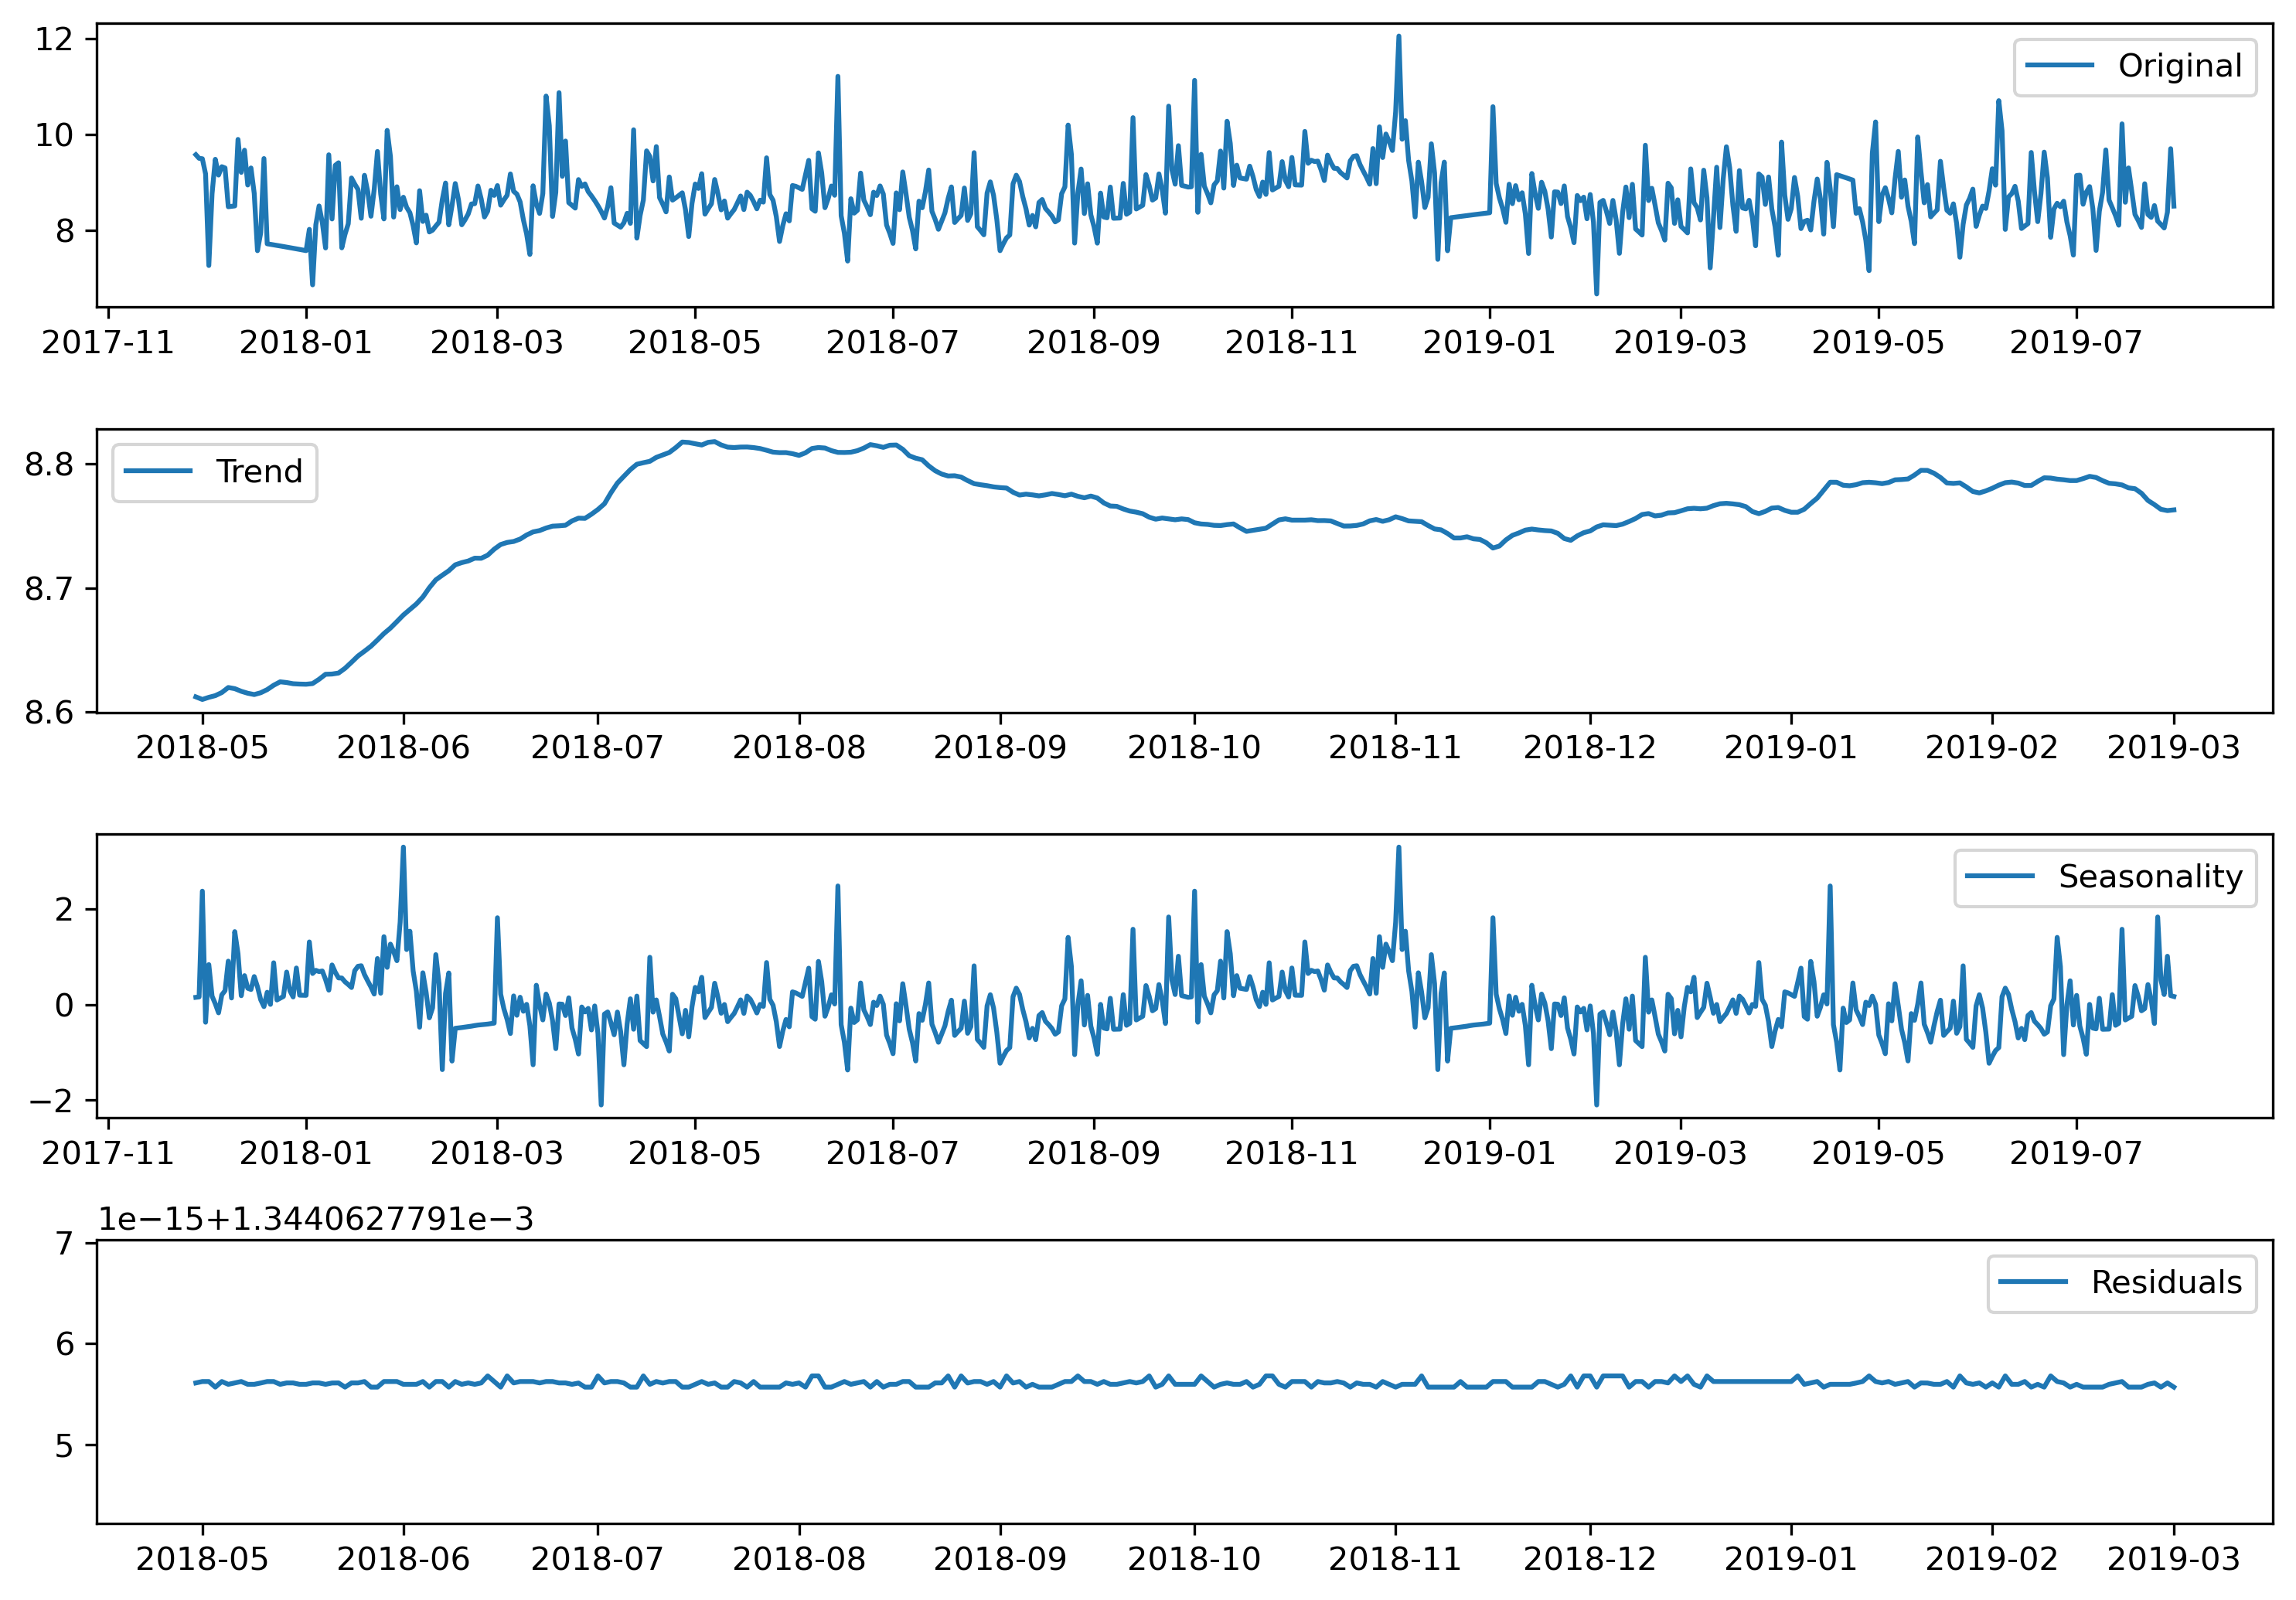

In [14]:
# Fill the missing datas to make data continuous and compatible with decompose function
ts = get_continuous(df_day,'1D')
## Decompose the data into trend, seasonality and residual
trend, seasonal, residual = get_decompose(ts, 'price',1)

Log transforming data and calculating ACF, PACF for ARIMA model

C:\Users\DineshNaik\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


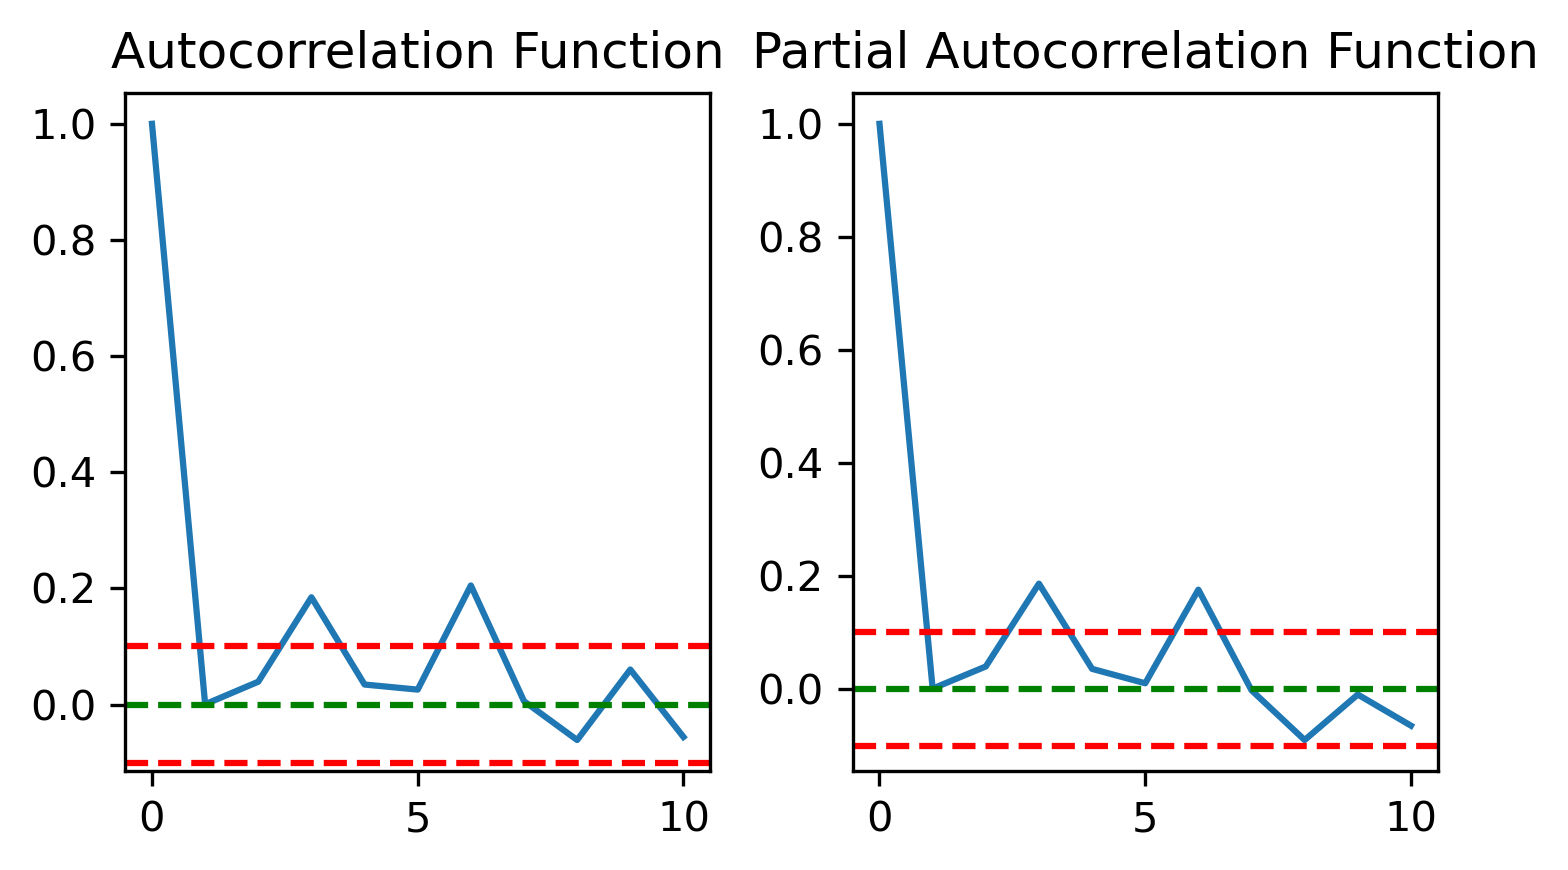

In [15]:
## Applying ACF and PACF 
get_ACF_PACF(df_day['price'],30)

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time which appears to be p=8.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time which is q=8.

It can be observed that log shifting by 30 days made the ARIMA much more accurate reducing the RSS

C:\Users\DineshNaik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\DineshNaik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


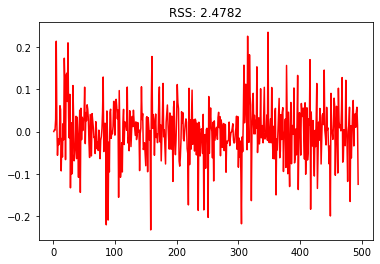

In [17]:
# ts_transformed = transform(ts_day, 30)
ts_transformed, ts_log_diff = log_shift(df_day['price'], 30)
fitted = fit_ARIMA(ts_transformed, 1)

C:\Users\DineshNaik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\DineshNaik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


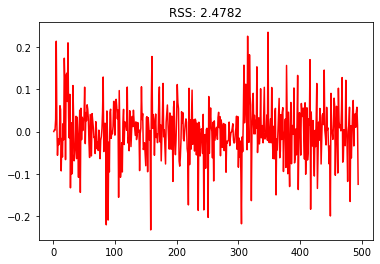

In [18]:
predictions = predict_ARIMA(ts_transformed,1)

In [19]:
predictions.head()

1   -0.000081
2    0.003923
3    0.003141
4    0.028523
5    0.214058
dtype: float64

In [20]:
ts_transformed.head()

0    9.578487
1    9.503902
2    9.494786
3    9.178569
4    7.274660
Name: price, dtype: float64

In [21]:
predictions_ARIMA_diff_cumsum = predictions.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

1   -0.000081
2    0.003843
3    0.006983
4    0.035506
5    0.249564
dtype: float64


In [22]:
predictions_ARIMA_log = pd.Series(ts_transformed.iloc[0], index=ts_transformed.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

0    9.578487
1    9.578407
2    9.582330
3    9.585471
4    9.613993
dtype: float64

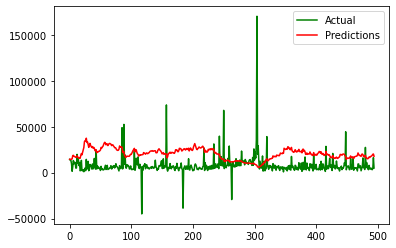

In [23]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df_day['price'], color='green', label='Actual')
plt.plot(predictions_ARIMA, color='red', label='Predictions')
plt.legend(loc='best')

In [24]:
np.sqrt((predictions_ARIMA-df_day['price'])**2)/len(df_day['price'])

0      1.102418e-14
1      2.095791e+00
2      2.456420e+00
3      9.827329e+00
4      2.733248e+01
           ...     
490    2.904505e+01
491    3.171115e+01
492    3.149250e+01
493    7.826828e+00
494    2.606417e+01
Length: 495, dtype: float64

Another model Prophet used for forecasting.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,7982.0,-1225.0,23269.0,7982.0,7982.0,3182.0,3182.0,3182.0,3182.0,3182.0,3182.0,0.0,0.0,0.0,11163.0
1,2017-11-29,7926.0,-3702.0,19140.0,7926.0,7926.0,-773.0,-773.0,-773.0,-773.0,-773.0,-773.0,0.0,0.0,0.0,7153.0
2,2017-11-30,7871.0,-1697.0,20750.0,7871.0,7871.0,940.0,940.0,940.0,940.0,940.0,940.0,0.0,0.0,0.0,8811.0
3,2017-12-01,7816.0,-3489.0,20811.0,7816.0,7816.0,607.0,607.0,607.0,607.0,607.0,607.0,0.0,0.0,0.0,8422.0
4,2017-12-02,7760.0,-5882.0,18010.0,7760.0,7760.0,-1531.0,-1531.0,-1531.0,-1531.0,-1531.0,-1531.0,0.0,0.0,0.0,6229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,2019-11-04,7670.0,-6901.0,22607.0,-330.0,14747.0,1093.0,1093.0,1093.0,1093.0,1093.0,1093.0,0.0,0.0,0.0,8763.0
707,2019-11-05,7675.0,-3635.0,25178.0,-463.0,14904.0,3182.0,3182.0,3182.0,3182.0,3182.0,3182.0,0.0,0.0,0.0,10857.0
708,2019-11-06,7680.0,-9271.0,20470.0,-612.0,15064.0,-773.0,-773.0,-773.0,-773.0,-773.0,-773.0,0.0,0.0,0.0,6907.0
709,2019-11-07,7685.0,-6379.0,23205.0,-733.0,15143.0,940.0,940.0,940.0,940.0,940.0,940.0,0.0,0.0,0.0,8625.0


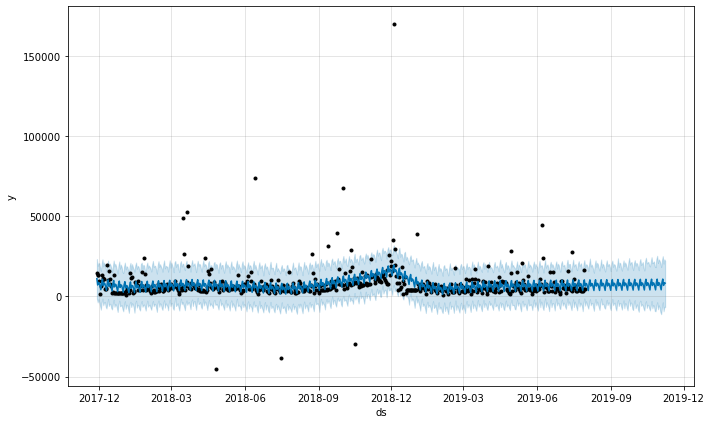

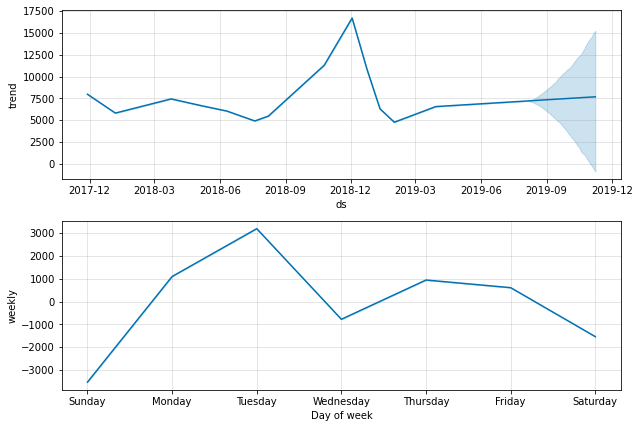

In [25]:
prophet_forecast(df_day,100,'1D')

In [26]:
m = Prophet()
ts = get_continuous(df_day,'1D')
df = pd.DataFrame()
df['ds'] = ts.index
df['y'] = ts.price.values
m.fit(df)
future = m.make_future_dataframe(periods=30)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
636,2019-08-26
637,2019-08-27
638,2019-08-28
639,2019-08-29
640,2019-08-30


In [27]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
636,2019-08-26,6543.913153,-6614.758512,18490.343097
637,2019-08-27,8634.887541,-4637.826460,21176.951999
638,2019-08-28,4662.165905,-8248.146393,16685.921583
639,2019-08-29,6342.806865,-6248.743665,18799.904154
640,2019-08-30,5994.240177,-5362.864555,19043.309968


Cross-validating fb prophet forecasting results

In [28]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='300 Days', period='100 Days', horizon='60 Days')
df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-11-13 00:00:00 and 2019-06-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-11-14,8234.329305,-2749.465210,19018.549349,10901.541,2018-11-13
1,2018-11-15,11493.472657,588.599109,22144.927979,10845.240,2018-11-13
2,2018-11-16,10169.725088,-826.614561,20928.884372,9973.500,2018-11-13
3,2018-11-17,8184.091056,-2285.561375,18758.622398,9441.605,2018-11-13
4,2018-11-18,6462.591652,-3894.633412,17156.359039,8909.710,2018-11-13


In [29]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days,9.158900e+07,9570.214386,4491.391938,0.479812,0.345153,0.944444
1,7 days,1.127790e+08,10619.747378,5361.206665,0.449994,0.345153,0.888889
2,8 days,1.152474e+08,10735.334109,5705.751701,0.492785,0.394144,0.888889
3,9 days,1.152712e+08,10736.440517,5657.735067,0.488543,0.394144,0.888889
4,10 days,1.134376e+08,10650.709051,5438.091515,0.494421,0.394144,0.888889


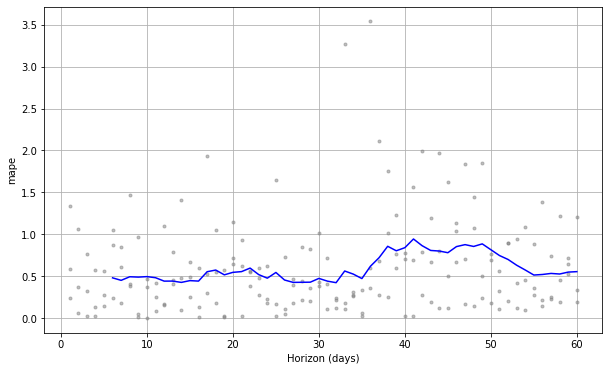

In [30]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.10)